# Learning ODE Parameters from Data

\begin{aligned}
y'(x) &= \beta y(x)\\
y(0) &= 1
\end{aligned}
where $\beta=2$ and the exact solution:
$$
y(x) = e^{2x}
$$

In [1]:
import torch

In [2]:
x = torch.linspace(0, 1, 100, requires_grad=True).reshape(-1, 1)

In [3]:
# Data

data_x = torch.tensor([0, 0.25, 0.5, 0.75, 1]).reshape(-1, 1)
data_y = torch.exp(2 * data_x)
data_y = data_y + torch.randn(data_x.shape) * 0.01
data_y

tensor([[1.0189],
        [1.6353],
        [2.7309],
        [4.4735],
        [7.3994]])

In [4]:
from torch import nn

In [5]:
mlp = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh(),
    nn.Linear(10, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
)

beta = torch.randn(1, requires_grad=True)
beta

tensor([1.7342], requires_grad=True)

In [6]:
import torch.optim as optim

optimizer = optim.Adam(list(mlp.parameters()) + [beta], lr=0.01)

In [7]:
def dy_dx(y, x):
    return torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]

In [8]:
losses = []

for i in range(1000):
    y = mlp.forward(x)
    y_p = dy_dx(y, x)

    residual_ode = y_p - beta * y

    residual_int = y[0] - 1

    data_pred = mlp.forward(data_x)
    residual_data = data_pred - data_y

    loss = (residual_ode**2).mean() + residual_int**2 + (residual_data**2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().numpy()[0])

    if i % 20 == 0:
        print(
            "Epoch %3d: Current loss: %.2e \t beta: %.2f"
            % (i, losses[-1], beta.detach().numpy()[0])
        )

Epoch   0: Current loss: 1.74e+01 	 beta: 1.72
Epoch  20: Current loss: 9.04e+00 	 beta: 1.53
Epoch  40: Current loss: 5.82e+00 	 beta: 1.33
Epoch  60: Current loss: 2.85e+00 	 beta: 1.14
Epoch  80: Current loss: 1.51e+00 	 beta: 1.08
Epoch 100: Current loss: 1.12e+00 	 beta: 1.20
Epoch 120: Current loss: 7.96e-01 	 beta: 1.32
Epoch 140: Current loss: 5.69e-01 	 beta: 1.43
Epoch 160: Current loss: 4.07e-01 	 beta: 1.52
Epoch 180: Current loss: 2.83e-01 	 beta: 1.59
Epoch 200: Current loss: 1.89e-01 	 beta: 1.66
Epoch 220: Current loss: 1.24e-01 	 beta: 1.72
Epoch 240: Current loss: 8.17e-02 	 beta: 1.77
Epoch 260: Current loss: 5.44e-02 	 beta: 1.81
Epoch 280: Current loss: 3.68e-02 	 beta: 1.85
Epoch 300: Current loss: 2.55e-02 	 beta: 1.88
Epoch 320: Current loss: 1.83e-02 	 beta: 1.90
Epoch 340: Current loss: 1.36e-02 	 beta: 1.92
Epoch 360: Current loss: 1.05e-02 	 beta: 1.94
Epoch 380: Current loss: 8.36e-03 	 beta: 1.95
Epoch 400: Current loss: 6.89e-03 	 beta: 1.96
Epoch 420: Cu

In [9]:
x_test = torch.linspace(0, 1, 31).reshape(-1, 1)
exact = torch.exp(2 * x_test)
predict = mlp.forward(x_test).detach().numpy()
error = exact - predict

MAE = torch.abs(error).mean()

print("Mean Absolute Error: %.2e" % MAE)

Mean Absolute Error: 2.46e-03


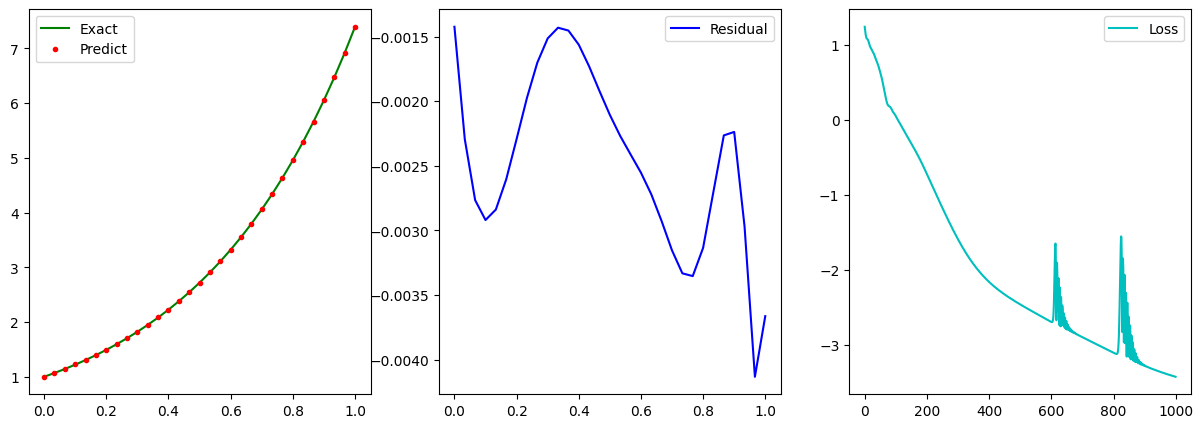

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(x_test, exact, "g-", label="Exact")
axs[0].plot(x_test, predict, "r.", label="Predict")

axs[1].plot(x_test, error, "b", label="Residual")

axs[2].plot(np.log10(losses), "c", label="Loss")

for ax in axs:
    ax.legend()